# Music Informatics Final Project: Song Transitions

1. **Feature extraction (Matej)** tempo, downbeats, key, energy, spectral flux, segmentation
2. **Tempo match & alignment (Bailin):** time-stretch song B to A's BPM, align downbeats, find overlap windows
3. **Transition scoring (Arvid):** score overlaps, pick best, apply crossfade, output the mix
4. **Evaluation & integration (Matei):** metrics, beat error, key distance, energy smoothness, listening, logging, report

1. **Feature extraction (Matej)** tempo, downbeats, key, energy, spectral flux, segmentation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
import librosa, librosa.display
import scipy
import pickle


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [ ]:
# Plot parameters
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [ ]:
def load_audio(path, sr=44100):
    """Load audio and return waveform + sample rate."""
    y, sr = librosa.load(path, sr=sr, mono=True)
    return y, sr


In [ ]:
# Load the songs
path1 = 'under_pressure.mp4'
path2 = 'billie_jean.mp3'
path3 = 'get_lucky.mp3'
y_under_pressure, sr = load_audio(path1)
y_billie_jean, sr = load_audio(path2)
y_get_lucky, sr = load_audio(path3)


/tmp/ipython-input-4193594893.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)


In [ ]:
def get_tempo_baseline(y, sr):
    """
    Compute the tempo and beat locations. Returns the global tempo over the whole
    song and the location of beats.
    """
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    return tempo[0], beat_times

In [ ]:
tempo_lib_1, beats_lib_1 = get_tempo_baseline(y_under_pressure, sr)
tempo_lib_2, beats_lib_2 = get_tempo_baseline(y_billie_jean, sr)
tempo_lib_3, beats_lib_3 = get_tempo_baseline(y_get_lucky, sr)

print(f"Tempo baseline: {tempo_lib_1:.1f} BPM, according to google should be ~112")
print(f"Tempo baseline: {tempo_lib_2:.1f} BPM, according to google should be ~117")
print(f"Tempo baseline: {tempo_lib_3:.1f} BPM, according to google should be ~116")

Tempo baseline: 112.3 BPM, according to google should be ~112
Tempo baseline: 117.5 BPM, according to google should be ~117
Tempo baseline: 114.8 BPM, according to google should be ~116


In [ ]:
def plot_beats_zoom(y, sr, beat_times, tempo, start_time=0.0, duration=5.0, margin_ratio=0.2):
    """
    Plot song waveform and beat locations for a specified time window.
    """
    # Get the specified segment
    start_sample = int(start_time * sr)
    end_sample = int((start_time + duration) * sr)
    y_segment = y[start_sample:end_sample]

    # Only keep beats within this segment
    mask = (beat_times >= start_time) & (beat_times <= start_time + duration)
    beats_in_window = beat_times[mask]

    # Compute amplitude limits (for nicer plot so it dynamically scales)
    y_max = np.max(np.abs(y_segment))
    y_margin = y_max * margin_ratio
    ymin, ymax = -y_max - y_margin, y_max + y_margin

    # Plot
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y_segment, sr=sr, alpha=0.7)
    plt.vlines(beats_in_window - start_time, ymin=ymin, ymax=ymax,
               color='r', linestyle='--', alpha=0.8, label='Beats')
    plt.ylim(ymin, ymax)
    plt.title(f"Beat Tracking (Zoomed) — Tempo ≈ {tempo:.1f} BPM\n"
              f"Window: {start_time:.1f} – {start_time+duration:.1f} s")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

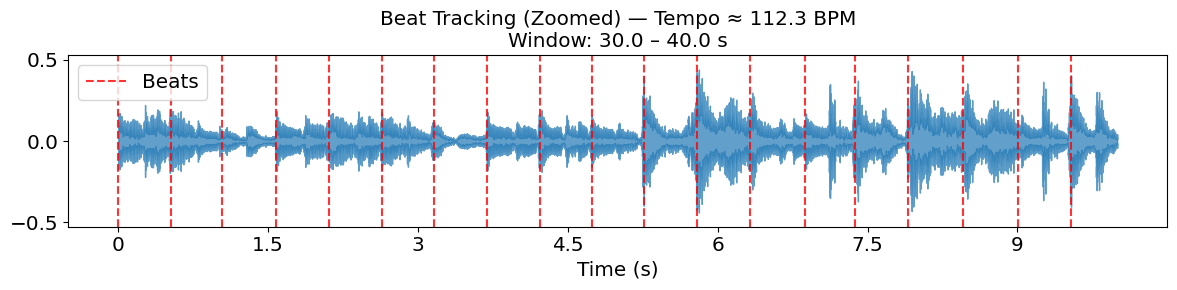

In [ ]:
plot_beats_zoom(y_under_pressure, sr, beats_lib_1, tempo_lib_1, start_time=30, duration=10)

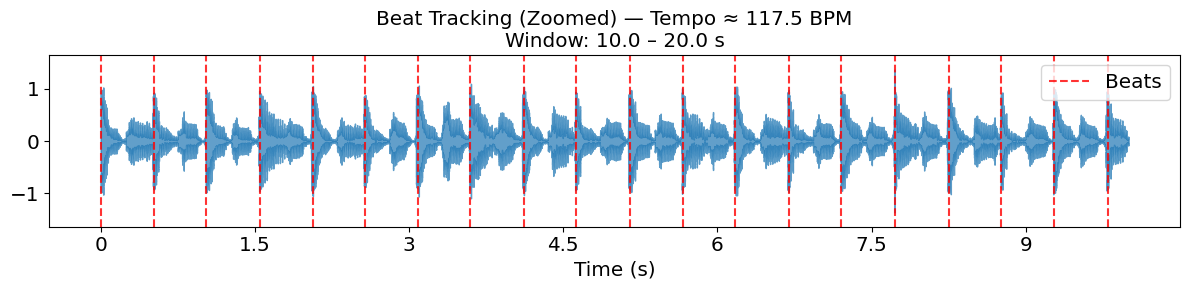

In [ ]:
plot_beats_zoom(y_billie_jean, sr, beats_lib_2, tempo_lib_2, start_time=10, duration=10)

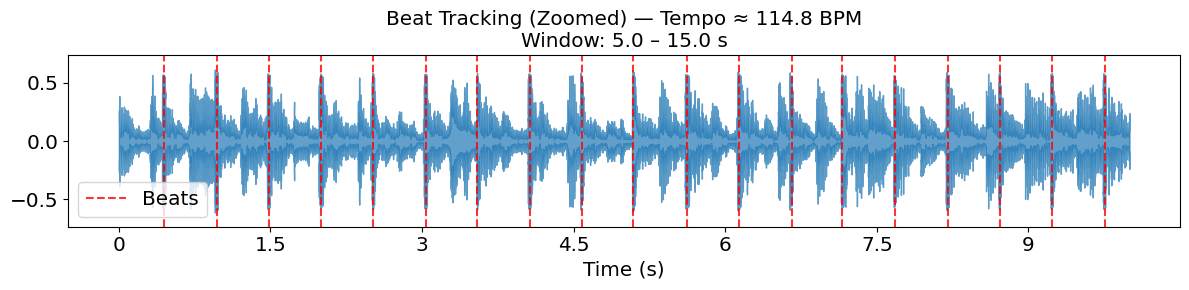

In [ ]:
plot_beats_zoom(y_get_lucky, sr, beats_lib_3, tempo_lib_3, start_time=5, duration=10)

In [ ]:
def get_downbeats_baseline(beat_times):
    """
    Get downbeats by assuming 4/4 time (same as paper) and the first beat is the '1'.
    """
    # Naive assumption: first beat is a downbeat. The paper uses a logistic regression classifier trained on manually annotated songs
    # to determine whether the first downbeat is on the first, second, third, or fourth beat.
    downbeat_times = beat_times[::4]
    return downbeat_times

Under Pressure: Found 453 beats and 114 downbeats.


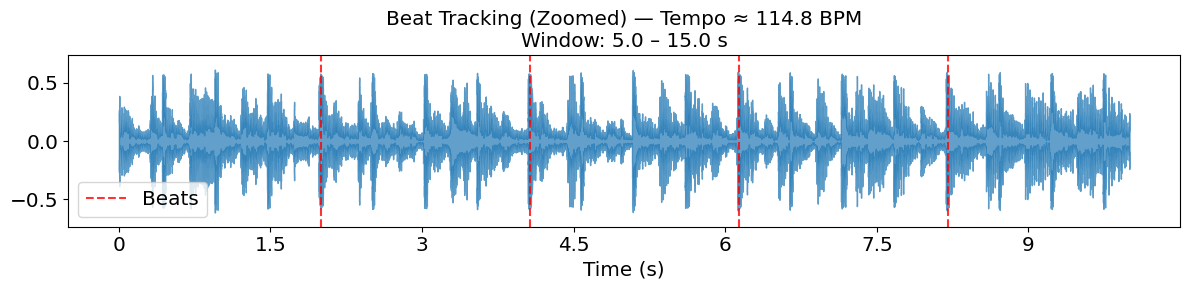

In [ ]:
downbeats_lib_1 = get_downbeats_baseline(beats_lib_1)
downbeats_lib_2 = get_downbeats_baseline(beats_lib_2)
downbeats_lib_3 = get_downbeats_baseline(beats_lib_3)

print(f"Under Pressure: Found {len(beats_lib_1)} beats and {len(downbeats_lib_1)} downbeats.")
plot_beats_zoom(y_get_lucky, sr, downbeats_lib_3, tempo_lib_3, start_time=5, duration=10)

In [ ]:
def get_key(y, sr):
    """
    Find the key of the song using chromagram
    """
    # Compute the chromagram
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    # Major/minor templates
    maj = np.array([1,0,0,0,1,0,0,1,0,0,0,0])
    min_ = np.array([1,0,0,1,0,0,0,1,0,0,1,0])
    labels = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    scores = []
    # Compute a correlation score for each key
    for i in range(12):
        scores.append(np.correlate(np.roll(maj, i), chroma_mean))
        scores.append(np.correlate(np.roll(min_, i), chroma_mean))
    best = np.argmax(scores)
    key_name = labels[best//2] + ('m' if best%2 else '')
    return key_name, float(np.max(scores))



In [ ]:
# Key
key_pap, conf_pap = get_key(y_under_pressure, sr)
print(f"Key baseline Under Pressure: {key_pap} ({conf_pap:.2f}), according to google should be D major")

key_pap, conf_pap = get_key(y_billie_jean, sr)
print(f"Key baseline Billie Jean: {key_pap} ({conf_pap:.2f}), according to google should be F sharp minor")

key_pap, conf_pap = get_key(y_get_lucky, sr)
print(f"Key baseline Get Lucky: {key_pap} ({conf_pap:.2f}), according to google should be F sharp minor")

Key baseline Under Pressure: Bm (2.09), according to google should be D major
Key baseline Billie Jean: F#m (2.15), according to google should be F sharp minor
Key baseline Get Lucky: Bm (2.58), according to google should be F sharp minor


In [ ]:
def get_energy_baseline(y, sr, hop_length=512):
    """
    Compute the RMS energy, which represents the loudness.
    """
    rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
    times = librosa.times_like(rms, sr=sr)
    return times, rms

In [ ]:
def plot_energy(times, energy, title="Energy (RMS over Time)", start_time=0.0, duration=30.0):
    """
    Plot energy (RMS) for a specified time window.
    """
    # Calculate end time
    end_time = start_time + duration

    # Get data only from the specified segment
    mask = (times >= start_time) & (times <= end_time)
    times_segment = times[mask]
    energy_segment = energy[mask]

    # Plot
    plt.figure()
    plt.plot(times_segment, energy_segment)
    plt.title(f"{title}\nWindow: {start_time:.1f} – {end_time:.1f} s")
    plt.xlabel("Time (s)")
    plt.ylabel("RMS Energy")
    plt.xlim(start_time, end_time)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

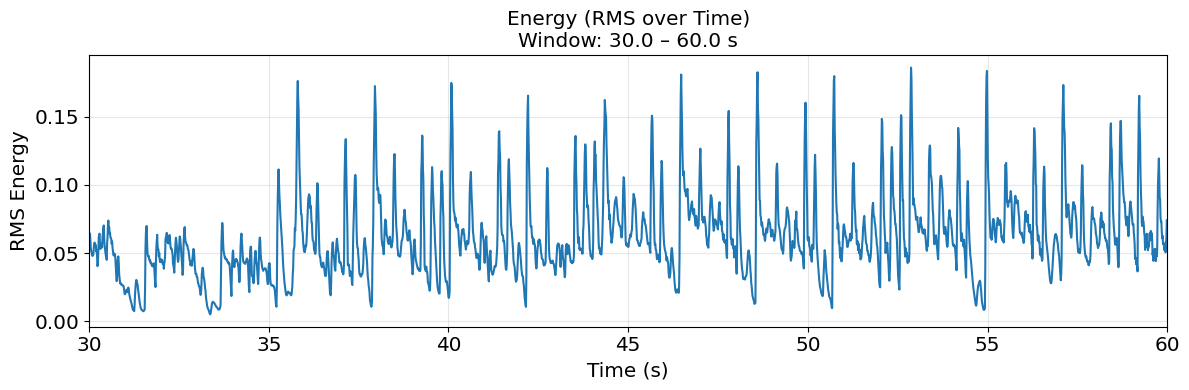

21801


In [ ]:
t_e, rms = get_energy_baseline(y_under_pressure, sr)
plot_energy(t_e, rms, start_time=30)

print(len(t_e))

In [ ]:
def get_spectral_flux_baseline(y, sr):
    """
    Compute the spectral flux using a melspectrogram.
    """
    # Use Melflux ODF
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, feature=librosa.feature.melspectrogram)
    times = librosa.times_like(onset_env, sr=sr)
    return onset_env, times

In [ ]:
def plot_flux(times, flux, title="Spectral Flux", start_time=0.0, duration=30.0):
    """
    Plot spectral flux for a specified time window.
    """
    # Calculate end time
    end_time = start_time + duration

    # Get data only from the specified segment
    mask = (times >= start_time) & (times <= end_time)
    times_segment = times[mask]
    flux_segment = flux[mask]

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(times_segment, flux_segment)
    plt.title(f"{title}\nWindow: {start_time:.1f} – {end_time:.1f} s")
    plt.xlabel("Time (s)")
    plt.ylabel("Flux (ΔSpectrum)")
    plt.xlim(start_time, end_time)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

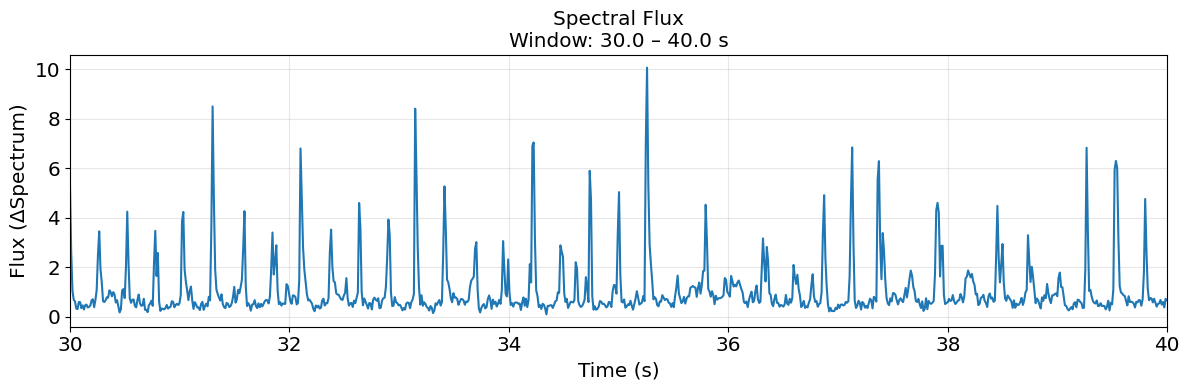

In [ ]:
flux_1, flux_times_1 = get_spectral_flux_baseline(y_under_pressure, sr)
plot_flux(flux_times_1, flux_1, start_time=30, duration=10)

In [ ]:
def get_segments_baseline(y, sr, hop_length=512):
    """
    Compute structural novelty curve and segment boundaries (baseline version).
    """
    # Step 1: Compute chroma
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)

    # Step 2: Build recurrence matrix (self-similarity)
    R = librosa.segment.recurrence_matrix(chroma, mode='affinity', sym=True)

    # Step 3: Gaussian blur for smoothing
    Rf = scipy.ndimage.gaussian_filter(R, sigma=1.0)

    # Step 4: Build kernel
    L = 16
    kernel = np.outer(np.concatenate([np.ones(L), -np.ones(L)]),
                      np.concatenate([-np.ones(L), np.ones(L)]))

    # Step 5: Compute novelty by 2D convolution along the diagonal
    novelty = np.zeros(Rf.shape[0])
    for i in range(L, Rf.shape[0]-L):
        novelty[i] = np.sum(Rf[i-L:i+L, i-L:i+L] * kernel)
    novelty = np.maximum(0, novelty)  # half-wave rectify

    # Step 6: Peak picking for boundaries
    peaks = librosa.util.peak_pick(novelty, pre_max=8, post_max=8,
                                   pre_avg=8, post_avg=8, delta=0.1, wait=10)
    boundaries = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length)

    return boundaries, novelty

In [ ]:
def plot_segments(novelty, boundaries, sr, hop_length=512, title="Structural Novelty"):
    """
    Plot structural novelty curve and segment boundaries.
    """
    times = librosa.frames_to_time(np.arange(len(novelty)), sr=sr, hop_length=hop_length)

    plt.figure()

    plt.plot(times, novelty, color='teal', alpha=0.7, label='Novelty curve')
    plt.vlines(boundaries, 0, np.max(novelty), color='r', linestyle='--', alpha=0.8, label='Segment boundaries')

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Novelty")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

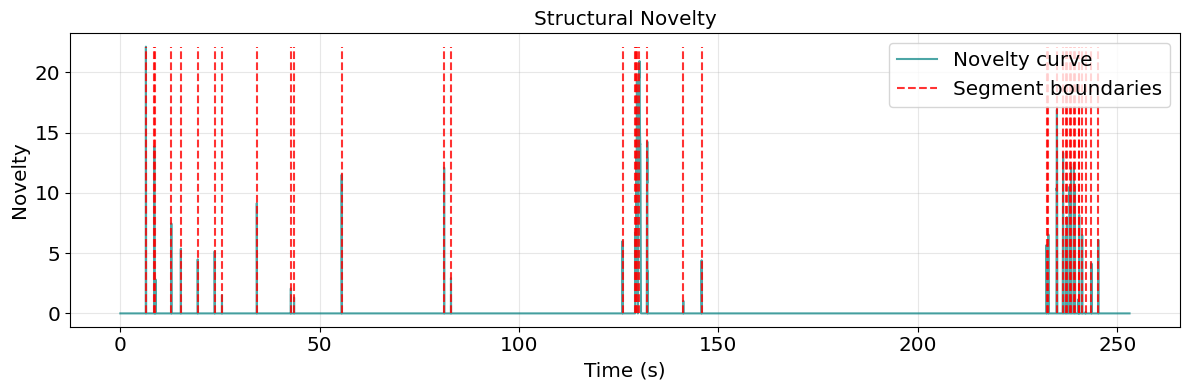

In [ ]:
boundaries, novelty = get_segments_baseline(y_under_pressure, sr)
plot_segments(novelty, boundaries, sr)

In [ ]:
def plot_segments_over_waveform(y, sr, boundary_times, title="Structural Segments"):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.7)
    plt.vlines(boundary_times, ymin=-1, ymax=1,
               color='r', linestyle='--', alpha=0.8, label='Segment boundaries')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

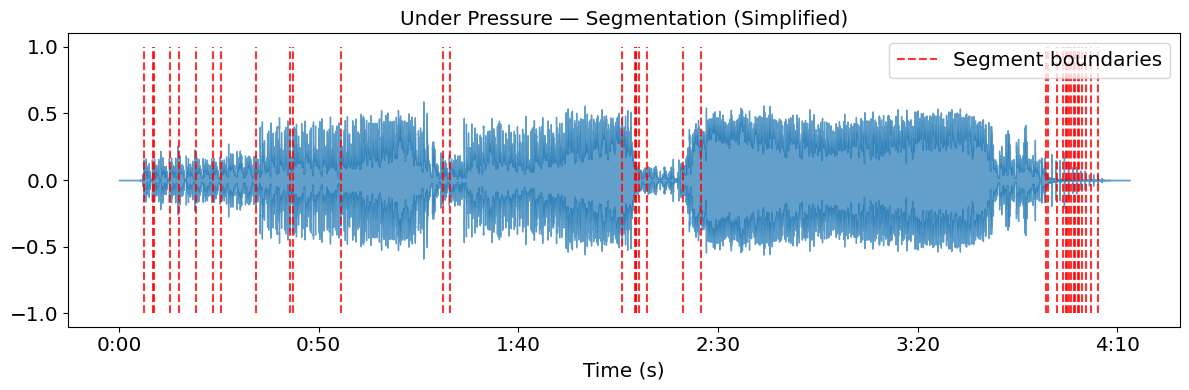

In [ ]:
plot_segments_over_waveform(y_under_pressure, sr, boundaries, title="Under Pressure — Segmentation (Simplified)")

In [ ]:
"""
Run all the code and all three songs (extend to more if we add them), store in dictionaries, save the dict. for quick retrieval
"""
print("Starting feature extraction for all songs...")

# All songs
audio_files = [
    ('Under Pressure', y_under_pressure),
    ('Billie Jean', y_billie_jean),
    ('Get Lucky', y_get_lucky)
]

song_library = []

# Loop through each song and extract all features
for name, y in audio_files:
    print(f"\nProcessing: {name}...")

    # 1. Tempo and Beats
    tempo, beat_times = get_tempo_baseline(y, sr)

    # 2. Downbeats
    downbeat_times = get_downbeats_baseline(beat_times)

    # 3. Key
    key, _ = get_key(y, sr)

    # 4. Energy (RMS)
    energy_values, energy_times = get_energy_baseline(y, sr)

    # 5. Spectral Flux
    flux_times, flux_values = get_spectral_flux_baseline(y, sr)

    # 6. Segmentation
    segment_boundaries, novelty_curve = get_segments_baseline(y, sr)

    # Create the dictionary for this song
    song_data = {
        'name': name,
        'y': y,
        'tempo': tempo,
        'beat_times': beat_times,
        'downbeat_times': downbeat_times,
        'key': key,
        'energy_values': energy_values,
        'energy_times': energy_times,
        'flux_values': flux_values,
        'flux_times': flux_times,
        'segment_boundaries': segment_boundaries,
        'novelty_curve': novelty_curve
    }

    song_library.append(song_data)

print("\nFeature extraction complete!")


# Save
filename = 'song_library.pkl'
with open(filename, 'wb') as f:
    pickle.dump(song_library, f)

Starting feature extraction for all songs...

Processing: Under Pressure...

Processing: Billie Jean...

Processing: Get Lucky...

--- Feature extraction complete! ---
Data for 3 songs stored in 'song_library' list.


Successfully loaded 3 songs from song_library.pkl

Loaded song name: Under Pressure
Loaded song tempo: 112.34714673913044


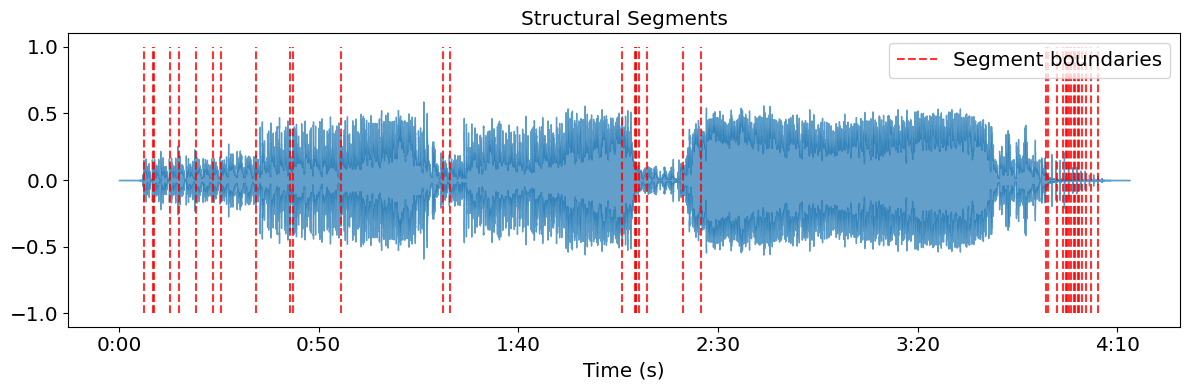

In [ ]:
"""
If you have the song_library file, you can use this to load all the data so no need to run everythinh
Could be useful as the segmentation takes about a minute or two (which is not a lot but a bit annoying)
"""

filename = 'song_library.pkl'

# Open the file in 'read-binary' (rb) mode and load the data
with open(filename, 'rb') as f:
    loaded_song_library = pickle.load(f)

print(f"Successfully loaded {len(loaded_song_library)} songs from {filename}")

# E.g. use like this
song_a = loaded_song_library[0]
print(f"\nLoaded song name: {song_a['name']}")
print(f"Loaded song tempo: {song_a['tempo']}")

plot_segments_over_waveform(song_a['y'], sr, song_a['segment_boundaries'])

2. **Tempo match & alignment (Bailin):** time-stretch song B to A's BPM, align downbeats, find overlap window

In [ ]:
import numpy as np
import librosa

def local_tempo(y, sr, center_s, window_s=10.0):
    """Estimate local tempo around center_s using a tempogram median."""
    # slice a window around the transition
    start = max(0, int((center_s - window_s/2) * sr))
    end   = min(len(y), int((center_s + window_s/2) * sr))
    y_win = y[start:end]

    # onset envelope -> tempogram -> local tempo curve
    onset_env = librosa.onset.onset_strength(y=y_win, sr=sr)
    tg = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
    # map tempogram to tempo (BPM) energies and take median of argmax over time
    tempi = librosa.tempo_frequencies(tg.shape[0], sr=sr)
    local_curve = tempi[np.argmax(tg, axis=0)]
    return float(np.median(local_curve))

def match_tempo_B_to_A(yA, yB, sr, transition_time_A_s=None):
    """
    Stretch track B so its tempo matches A (globally or locally near transition_time_A_s).
    Returns stretched yB and the stretch rate used.
    """
    if transition_time_A_s is None:
        # fall back to global tempos
        tempoA, _ = librosa.beat.beat_track(y=yA, sr=sr)
        tempoB, _ = librosa.beat.beat_track(y=yB, sr=sr)
    else:
        tempoA = local_tempo(yA, sr, center_s=transition_time_A_s, window_s=12.0)
        # estimate local tempo in B near its start (or your chosen B entry time)
        tempoB = local_tempo(yB, sr, center_s=0.0, window_s=12.0)

    # guard
    tempoB = max(tempoB, 1e-6)
    rate = float(tempoA / tempoB)

    # librosa phase-vocoder preserves pitch while changing duration/tempo
    yB_stretched = librosa.effects.time_stretch(yB, rate=rate)

    # optional: verify
    new_tempoB, _ = librosa.beat.beat_track(y=yB_stretched, sr=sr)
    # print(f"Debug BPM: A≈{tempoA:.2f}, B_before≈{tempoB:.2f}, B_after≈{new_tempoB:.2f}, rate={rate:.4f}")

    return yB_stretched, rate


In [ ]:
# 1. MATCH TEMPO
# ratio = get_tempo_baseline(y_A) / get_tempo_baseline(y_B)
# librosa.effects.time_stretch(y_A, ratio)

# 2. START NEW SONG AT 20TH LAST BEAT OF FIRST SONG
# 20

# 3. MATCH ENERGY
# crossfade A into B


# 4. MATCH PITCH
# (EITHER LIBROSA)
# https://librosa.org/doc/0.11.0/generated/librosa.effects.pitch_shift.html

# (OR TORCH)
# https://pypi.org/project/torch-pitch-shift/#
# https://kentonishi.com/torch-pitch-shift/usage/

3. **Transition scoring (Arvid):** generate outputs, evaluation.

4. **Evaluation & integration (Matei):** evaluation, logging, report

Resources:
https://asmp-eurasipjournals.springeropen.com/articles/10.1186/s13636-018-0134-8